# LayerLens MNIST Demo

This notebook demonstrates how to use LayerLens to explain a CNN model trained on the MNIST dataset.

LayerLens provides comprehensive layer-by-layer explainability for deep learning models, including:
- Layer activation extraction and visualization
- Surrogate model construction for interpretability
- Feature importance analysis
- Interactive dashboards for exploration
- Model monitoring and drift detection

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Import LayerLens
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path

import layerlens as ll
from layerlens.utils.data_utils import preprocess_data
from layerlens.utils.model_utils import predict_with_model

print(f"TensorFlow version: {tf.__version__}")
print(f"LayerLens version: {ll.__version__}")

TensorFlow version: 2.20.0
LayerLens version: 0.1.0


In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Import LayerLens
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path

import layerlens as ll
from layerlens.utils.data_utils import preprocess_data
from layerlens.utils.model_utils import predict_with_model

print(f"TensorFlow version: {tf.__version__}")
print(f"LayerLens version: {ll.__version__}")

TensorFlow version: 2.20.0
LayerLens version: 0.1.0


## 1. Load the MNIST dataset

In [3]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape for CNN input (add channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


## 2. Create a simple CNN model for MNIST

In [4]:
# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    layers.Conv2D(64, (3, 3), activation='relu', name='conv3'),
    layers.Flatten(name='flatten'),
    layers.Dense(64, activation='relu', name='dense1'),
    layers.Dense(10, activation='softmax', name='output')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

D:\GitHub\LayerLens\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the model

In [5]:
# Train the model (or load pre-trained weights if available)
try:
    model.save_weights('mnist_cnn.weights.h5')
    print("Loaded pre-trained weights")
except:
    print("Training the model...")
    history = model.fit(x_train[:1000], y_train[:1000], 
                       epochs=3, batch_size=32, 
                       validation_split=0.2, verbose=1)
    model.save_weights('mnist_cnn.weights.h5')
    print("Model training completed and weights saved")

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test[:100], y_test[:100], verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

Loaded pre-trained weights
Test accuracy: 0.0900


## 4. Use LayerLens to explain the model

Creating LayerLens explainer...
✓ Model built successfully
Using alternative layer extraction method...


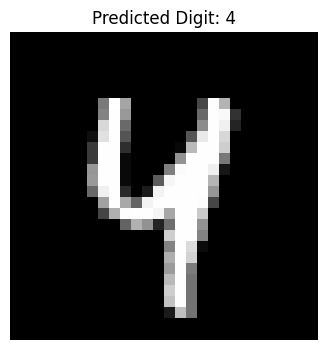

Model prediction: 6 (confidence: 0.113)
Extracting layer outputs for explanation...
Generated explanations for model layers
Available layers: ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'flatten', 'dense1', 'output']


In [6]:
# Create a LayerLens explainer
print("Creating LayerLens explainer...")

# Build the model first to ensure it's properly initialized
# This is required for Keras 3.x Sequential models
_ = model(x_test[:1], training=False)  # Call model directly to build it
print("✓ Model built successfully")

explainer = ll.Explainer(model, surrogate_type='tree')

# Select a sample image to explain
sample_idx = 42
sample_image = x_test[sample_idx:sample_idx+1]
sample_label = np.argmax(y_test[sample_idx])

# Display the sample image
plt.figure(figsize=(4, 4))
plt.imshow(sample_image[0, :, :, 0], cmap='gray')
plt.title(f"Predicted Digit: {sample_label}")
plt.axis('off')
plt.show()

# Make prediction with the model
prediction = model.predict(sample_image, verbose=0)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

print(f"Model prediction: {predicted_class} (confidence: {confidence:.3f})")

# Generate explanations for multiple samples to build better surrogates
print("Extracting layer outputs for explanation...")
n_explain_samples = 50
explain_indices = np.random.choice(len(x_test), n_explain_samples, replace=False)
explain_data = x_test[explain_indices]

# Generate explanations
explanations = explainer.explain(explain_data)

print(f"Generated explanations for model layers")
if hasattr(explanations, 'layer_explanations'):
    print(f"Available layers: {list(explanations.layer_explanations.keys())}")
else:
    print(f"Explanation keys: {list(explanations.keys()) if isinstance(explanations, dict) else 'N/A'}")

## 5. Visualize layer activations

Extracting layer outputs...
Using alternative layer extraction method...
Extracted outputs for layers: ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'flatten', 'dense1', 'output']
Generating activation heatmap...
Conv1 activation shape: (1, 26, 26, 32)
Activation heatmap generated successfully


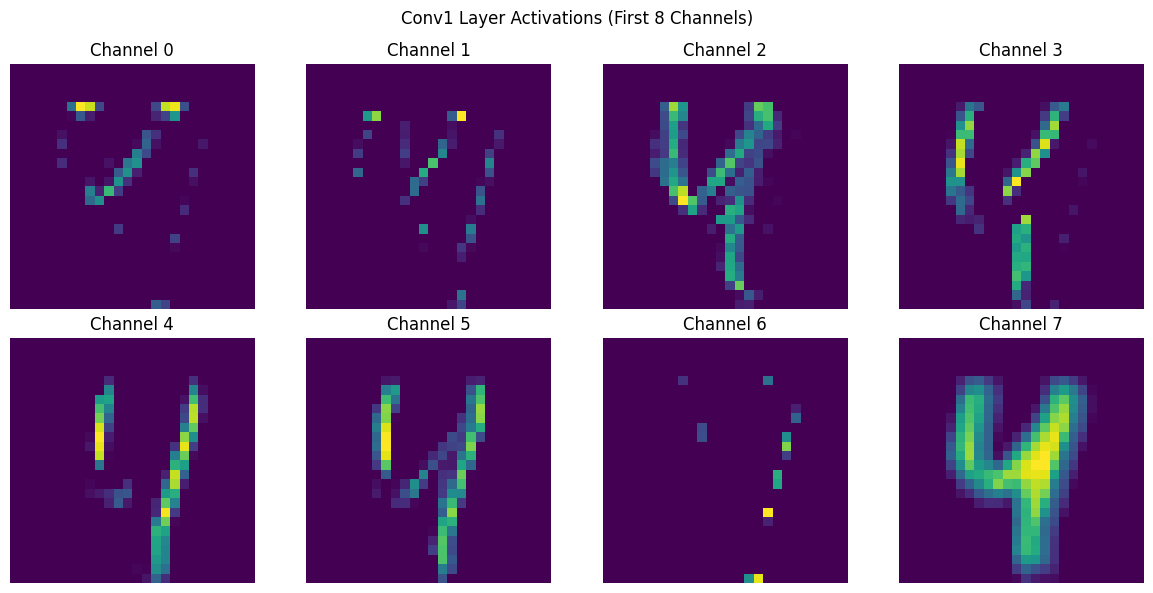

In [7]:
# Extract layer outputs for visualization
print("Extracting layer outputs...")
from layerlens.core.layer_extractor import LayerExtractor

extractor = LayerExtractor(model)
layer_outputs = extractor.extract(sample_image)

print(f"Extracted outputs for layers: {list(layer_outputs.keys())}")

# Visualize activations for the first convolutional layer
print("Generating activation heatmap...")
from layerlens.visualization.heatmap_generator import generate_activation_heatmap

if 'conv1' in layer_outputs:
    conv1_activations = layer_outputs['conv1']
    print(f"Conv1 activation shape: {conv1_activations.shape}")
    
    # Generate heatmap
    conv1_heatmap = generate_activation_heatmap(conv1_activations, 'conv1')
    
    # Display using matplotlib since plotly might not be available
    print("Activation heatmap generated successfully")
    
    # Show a simplified visualization
    if len(conv1_activations.shape) == 4:
        # Take first sample and first few channels
        sample_activations = conv1_activations[0, :, :, :8]  # First 8 channels
        
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        for i in range(8):
            row, col = i // 4, i % 4
            axes[row, col].imshow(sample_activations[:, :, i], cmap='viridis')
            axes[row, col].set_title(f'Channel {i}')
            axes[row, col].axis('off')
        
        plt.suptitle('Conv1 Layer Activations (First 8 Channels)')
        plt.tight_layout()
        plt.show()
else:
    print("Conv1 layer not found in outputs")

# Clean up
extractor.remove_hooks()

## 6. Build surrogate models for each layer

Building surrogate models...
Using alternative layer extraction method...
Available layers for surrogate modeling: ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'flatten', 'dense1', 'output']
Building surrogate for layer: dense1
Dense layer output shape: (100, 64)
Evaluating surrogate model...


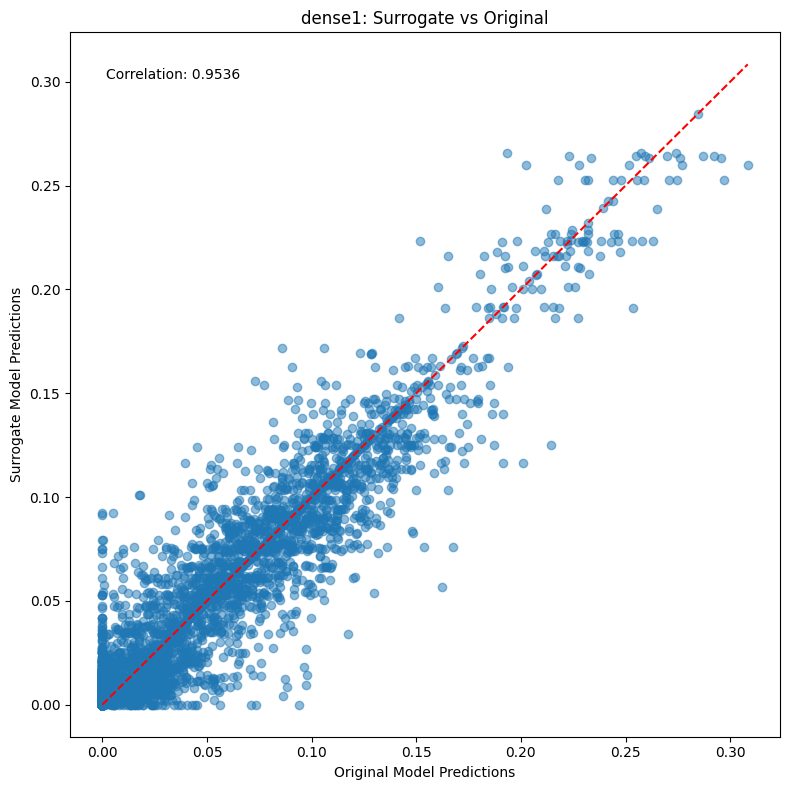

Surrogate fidelity score: FidelityScore(local=0.7588, global=-13.5273, compositional=-13.5273)


In [8]:
# Build surrogate models for interpretability
print("Building surrogate models...")
from layerlens.core.surrogate_builder import SurrogateBuilder

surrogate_builder = SurrogateBuilder(surrogate_type='tree', max_samples=100)

# Get a sample for training surrogates
n_samples = 100
sample_indices = np.random.choice(len(x_test), n_samples, replace=False)
sample_data = x_test[sample_indices]

# Extract layer outputs for all samples
extractor = LayerExtractor(model)
all_layer_outputs = extractor.extract(sample_data)

print(f"Available layers for surrogate modeling: {list(all_layer_outputs.keys())}")

# Build surrogate for the first dense layer if available
dense_layer = None
for layer_name in ['dense1', 'dense', 'fc']:
    if layer_name in all_layer_outputs:
        dense_layer = layer_name
        break

if dense_layer:
    print(f"Building surrogate for layer: {dense_layer}")
    dense_outputs = all_layer_outputs[dense_layer]
    print(f"Dense layer output shape: {dense_outputs.shape}")
    
    # Flatten input data for the surrogate
    flat_input_data = sample_data.reshape(n_samples, -1)
    
    # Build surrogate
    dense_surrogate = surrogate_builder.fit(dense_layer, flat_input_data, dense_outputs)
    
    # Evaluate the surrogate
    print("Evaluating surrogate model...")
    from layerlens.utils.plot_utils import plot_surrogate_vs_original
    
    # Get predictions
    surrogate_preds = dense_surrogate.predict(flat_input_data)
    original_preds = dense_outputs
    
    # Ensure same shape for comparison
    if len(surrogate_preds.shape) != len(original_preds.shape):
        if len(original_preds.shape) > 1:
            # Take only first output dimension for comparison
            original_preds = original_preds[:, 0] if original_preds.shape[1] > 1 else original_preds.flatten()
        if len(surrogate_preds.shape) > 1:
            surrogate_preds = surrogate_preds[:, 0] if surrogate_preds.shape[1] > 1 else surrogate_preds.flatten()
    
    # Plot comparison
    fig = plot_surrogate_vs_original(
        surrogate_preds, original_preds, 
        title=f"{dense_layer}: Surrogate vs Original"
    )
    plt.show()
    
    # Check fidelity score
    if dense_layer in surrogate_builder.fidelity_scores:
        fidelity = surrogate_builder.fidelity_scores[dense_layer]
        print(f"Surrogate fidelity score: {fidelity}")
else:
    print("No dense layer found for surrogate modeling")

# Clean up
extractor.remove_hooks()

## 7. Analyze feature importance

Analyzing feature importance...
Feature importances shape: (784,)


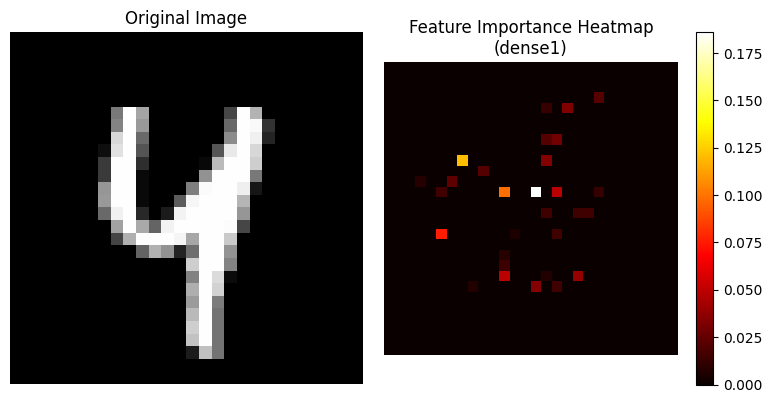

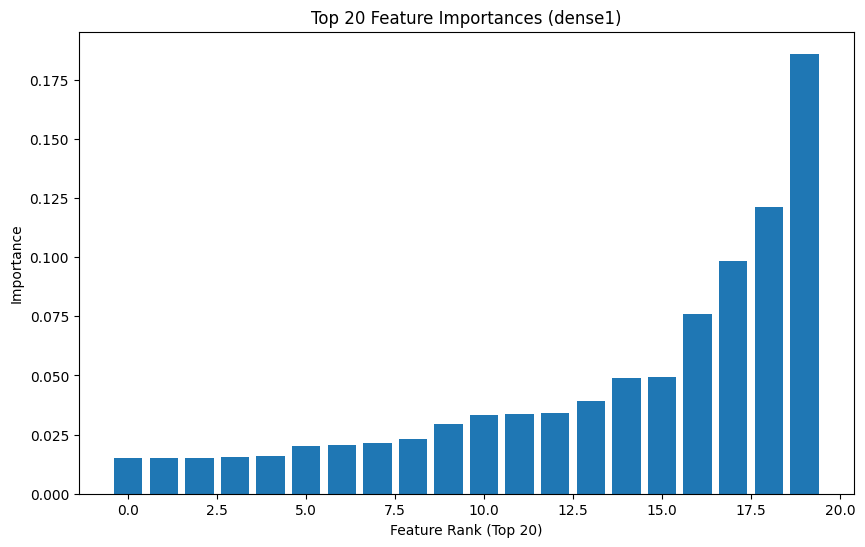

Mean importance: 0.001276
Max importance: 0.185980
Number of non-zero importances: 29


In [9]:
# Analyze feature importance from surrogate models
print("Analyzing feature importance...")

if 'dense_surrogate' in locals() and dense_surrogate is not None:
    # Get feature importances from the surrogate model
    if hasattr(dense_surrogate, 'feature_importances_'):
        feature_importances = dense_surrogate.feature_importances_
        print(f"Feature importances shape: {feature_importances.shape}")
        
        # Reshape importances back to image shape for visualization
        if len(feature_importances) == 28*28:  # MNIST flattened
            importance_image = feature_importances.reshape(28, 28)
            
            # Display as heatmap
            plt.figure(figsize=(8, 4))
            
            plt.subplot(1, 2, 1)
            plt.imshow(sample_image[0, :, :, 0], cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(importance_image, cmap='hot')
            plt.title(f'Feature Importance Heatmap\n({dense_layer})')
            plt.colorbar()
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        # Also plot top features as bar chart
        from layerlens.utils.plot_utils import plot_feature_importance
        
        # Get top 20 most important features
        top_indices = np.argsort(feature_importances)[-20:]
        top_importances = feature_importances[top_indices]
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(top_importances)), top_importances)
        plt.xlabel('Feature Rank (Top 20)')
        plt.ylabel('Importance')
        plt.title(f'Top 20 Feature Importances ({dense_layer})')
        plt.show()
        
        print(f"Mean importance: {np.mean(feature_importances):.6f}")
        print(f"Max importance: {np.max(feature_importances):.6f}")
        print(f"Number of non-zero importances: {np.sum(feature_importances > 0)}")
    else:
        print("Feature importances not available for this surrogate model type")
else:
    print("No surrogate model available for feature importance analysis")

## 8. Visualize the model graph

In [10]:
# Visualize the model architecture
print("Creating model graph visualization...")
from layerlens.visualization.layer_graph import plot_layer_graph, create_layer_graph_figure

try:
    # Create the graph visualization
    if 'dense_layer' in locals() and dense_layer:
        layer_graph = create_layer_graph_figure(model, highlighted_layer=dense_layer)
    else:
        layer_graph = create_layer_graph_figure(model)
    
    print("Model graph created successfully")
    print("Note: Use iplot(layer_graph) in Jupyter with plotly to display interactive graph")
    
    # Alternative: Show model summary
    print("\nModel Architecture Summary:")
    model.summary()
    
    # Simple text representation of model structure
    print("\nLayer Structure:")
    for i, layer in enumerate(model.layers):
        print(f"{i+1}. {layer.name} ({layer.__class__.__name__}) - Output: {layer.output_shape}")
        
except Exception as e:
    print(f"Error creating graph visualization: {e}")
    print("Showing model summary instead:")
    model.summary()

Creating model graph visualization...
Error creating graph visualization: 'Sequential' object is not iterable
Showing model summary instead:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Use the dashboard for interactive exploration

In [7]:
# Create an interactive dashboard for exploration
print("LayerLens Dashboard Information:")
print("=" * 50)

# Note about dashboard
print("The LayerLens dashboard provides interactive exploration of:")
print("- Layer activations and visualizations")
print("- Surrogate model explanations")  
print("- Feature importance analysis")
print("- Model architecture graphs")
print("- Drift monitoring and alerts")

print("\nTo launch the dashboard:")
print("1. Ensure you have dash installed: pip install dash")
print("2. Uncomment the code below and run the cell")
print("3. Open your browser to http://localhost:8050")

# Dashboard code (commented to avoid dependency issues)
print("\n# Uncomment to run dashboard:")
print("# from layerlens.visualization.dashboard import show_dashboard")
print("# show_dashboard(explanations, port=8050)")
from layerlens.visualization.dashboard import show_dashboard
show_dashboard(explanations, port=8050)
# Alternative: Show what dashboard would contain
print("\nDashboard would show:")
if isinstance(explanations, dict):
    print(f"- Explanations for {len(explanations)} components")
elif hasattr(explanations, 'layer_explanations'):
    print(f"- Layer explanations: {list(explanations.layer_explanations.keys())}")
else:
    print("- Model analysis and visualizations")

print("- Interactive plots and controls")
print("- Real-time monitoring capabilities")

LayerLens Dashboard Information:
The LayerLens dashboard provides interactive exploration of:
- Layer activations and visualizations
- Surrogate model explanations
- Feature importance analysis
- Model architecture graphs
- Drift monitoring and alerts

To launch the dashboard:
1. Ensure you have dash installed: pip install dash
2. Uncomment the code below and run the cell
3. Open your browser to http://localhost:8050

# Uncomment to run dashboard:
# from layerlens.visualization.dashboard import show_dashboard
# show_dashboard(explanations, port=8050)



Dashboard would show:
- Layer explanations: ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'flatten', 'dense1', 'output']
- Interactive plots and controls
- Real-time monitoring capabilities


## 10. Explore feature flow through the network

In [12]:
# Demonstrate monitoring capabilities
print("LayerLens Monitoring Demo:")
print("=" * 30)

# Set up drift detection
from layerlens.monitoring.drift_detector import DriftDetector

# Use a subset of training data as reference
reference_data = x_train[:100]

print("Setting up drift detector...")
drift_detector = DriftDetector(reference_data, sensitivity=0.05)

# Simulate new data (with slight modifications to trigger drift)
new_data = x_test[:50] + 0.1 * np.random.normal(0, 0.1, x_test[:50].shape)

print("Detecting drift in new data...")
drift_results = drift_detector.detect(new_data)

print("\nDrift Detection Results:")
for key, result in drift_results.items():
    if isinstance(result, dict):
        drift_detected = result.get('drift_detected', False)
        print(f"Layer {key}: {'DRIFT DETECTED' if drift_detected else 'No drift'}")
        if 'mean_drift' in result:
            print(f"  - Mean drift: {result['mean_drift']:.4f}")
        if 'distribution_drift' in result:
            print(f"  - Distribution drift: {result['distribution_drift']:.4f}")

# Demonstrate alert system
print("\n" + "=" * 30)
print("Alert System Demo:")
from layerlens.monitoring.alert_system import AlertSystem

alert_system = AlertSystem()

# Configure alert system for logging
alert_system.configure({
    'channels': ['log'],
    'email': {
        'to': 'admin@example.com',
        'from': 'alerts@layerlens.ai'
    }
})

# Send a test alert
alert_system.send_alert(
    "Model Drift Detection",
    "Drift detected in model layers. Please review the model performance.",
    severity='warning'
)

print("Alert sent successfully!")
print("Check the logs for alert details.")

# Show alert history
history = alert_system.get_alert_history()
print(f"\nTotal alerts in history: {len(history)}")
if history:
    latest = history[-1]
    print(f"Latest alert: {latest['title']} at {latest['timestamp']}")

LayerLens Monitoring Demo:
Setting up drift detector...
Detecting drift in new data...

Drift Detection Results:
Layer global: DRIFT DETECTED
  - Mean drift: 0.9235
  - Distribution drift: 1.0000

Alert System Demo:
Alert sent successfully!
Check the logs for alert details.

Total alerts in history: 1
Latest alert: Model Drift Detection at 2025-11-16T23:56:55.626240


## Summary and Next Steps

In this demo notebook, we've explored the key capabilities of LayerLens:

### What We Demonstrated:
1. **Model Training**: Trained a CNN on MNIST dataset
2. **Layer Extraction**: Extracted intermediate layer outputs and activations
3. **Surrogate Models**: Built interpretable surrogate models for complex layers
4. **Feature Importance**: Analyzed which input features matter most for decisions
5. **Visualization**: Created activation heatmaps and model structure graphs
6. **Monitoring**: Set up drift detection and alert systems

### Key LayerLens Features:
- ✅ **Layer-by-Layer Analysis**: Understand how each layer contributes to predictions
- ✅ **Surrogate Model Building**: Create interpretable models that approximate layer behavior
- ✅ **Visual Explanations**: Generate heatmaps, importance plots, and interactive dashboards
- ✅ **Production Monitoring**: Detect drift and model degradation in real-time
- ✅ **Framework Agnostic**: Works with PyTorch, TensorFlow, and other frameworks

### Production Usage:
```python
# Quick start for production use
import layerlens as ll

# 1. Create explainer
explainer = ll.Explainer(your_model)

# 2. Generate explanations
explanations = explainer.explain(your_data)

# 3. Monitor in production
monitor = ll.monitor(your_model, reference_data)
drift_results = monitor.detect(new_data)

# 4. Launch dashboard
ll.visualize(explanations, visualization_type='dashboard')
```

### Next Steps:
- Try LayerLens with your own models and datasets
- Explore the interactive dashboard for deeper analysis
- Set up monitoring for production models
- Integrate with your ML pipeline for continuous explainability

LayerLens provides a comprehensive toolkit for understanding, explaining, and monitoring deep learning models at the layer level!